# Analysis

As always, we start by importing our necessary packages.

In [286]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm
from scipy.stats import shapiro
from scipy.stats import kendalltau
from scipy.stats.distributions import norm
from scipy.optimize import curve_fit

## The Data

Let's import our processed CSV's. There are three to keep track of here:

<font color = 'blue'><b>1) control_norm.csv:</b></font> This dataframe tracks log mRNA proportions for all patients in the CONTROL group. <br>
<font color = 'blue'><b>2) rsv_norm.csv: </b></font> This dataframe tracks log mRNA proportions for all patients in the RSV group. <br>
<font color = 'blue'><b>3) mRNA_signals.csv: </b></font> This dataframe tracks log mRNA proportions for all genes and patients.

Our initial goal here is to <b><font color = 'red'>identify which genes exhibit significant differences in expression between 
control patients and RSV patients</b></font>. To that end, we'll be conducting numerous paired t-tests, using Benjamini-Hochberg to adjust for the multiple-testing fallacy.

In [10]:
# Load in CSVs
control = pd.read_csv('../PROCESSED_DATA/control_norm.csv', header = 0, index_col = 0)
rsv = pd.read_csv('../PROCESSED_DATA/rsv_norm.csv', header = 0, index_col = 0)
mRNA_signals = pd.read_csv('../PROCESSED_DATA/normalized_mRNA_counts.csv', index_col = 0)
pd.set_option('display.max_columns', None) # We'd like to be able to view all columns

genes = control.index # List of all gene candidates

# Obtain mean gene mRNA signal for controls and RSV group
con_mean = control.mean(axis = 1)
rsv_mean = rsv.mean(axis = 1)

# Obtain variance of gene mRNA signal for controls and RSVP group
con_var = control.var(axis = 1)
rsv_var = rsv.var(axis = 1)

# Obtain sample size for controls and RSVP group
con_n = len(control.columns)
rsv_n = len(rsv.columns)

# Compute Z-scores and p-values
Z = (con_mean - rsv_mean) / np.sqrt(con_var / con_n + rsv_var / rsv_n)
p_values = 2 * norm.sf(abs(Z))


########################### TRY BENJAMINI - HOCHBERG ADJUSTMENT ########################### 

b_hoch = multipletests(p_values, alpha = 0.05, method = 'fdr_bh')
rejects = b_hoch[0]
adjusted_p_vals = b_hoch[1]

# Generate a new dataframe with Benjamini - Hochberg statistics for each gene candidate
bhoch_genes = pd.DataFrame({"Gene": genes, "Mean Diff": rsv_mean - con_mean, "Initial p-val": p_values, 
                            "Adjusted p-values": adjusted_p_vals, "Reject?": rejects})


bhoch_genes.to_csv("../PROCESSED_DATA/all_bhoch_genes.csv") # Write to CSV

# Filter out only the significant genes, reformat and save CSV
bhoch_sig_genes = bhoch_genes[bhoch_genes["Reject?"] == True]
bhoch_sig_genes = bhoch_sig_genes.reset_index()
bhoch_sig_genes.set_index("Gene", inplace = True)
bhoch_sig_genes.index.name = None
bhoch_sig_genes.drop(["index", "Reject?"], inplace = True, axis = 1)
bhoch_sig_genes.sort_values("Adjusted p-values", inplace = True, ascending = True)
bhoch_sig_genes.to_csv("../PROCESSED_DATA/sig_bhoch_genes.csv") # Write to CSV

print("The number of significant genes is: ", bhoch_sig_genes.shape[0])
bhoch_sig_genes.head(5)


##################################################################################################


The number of significant genes is:  220


C:\Users\krdon\AppData\Local\Temp\ipykernel_940\3849332636.py:4: DtypeWarning: Columns (28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64) have mixed types. Specify dtype option on import or set low_memory=False.
  mRNA_signals = pd.read_csv('../PROCESSED_DATA/normalized_mRNA_counts.csv', index_col = 0)


,Mean Diff,Initial p-val,Adjusted p-values
ERCC6L,0.818106,9.242973e-10,0.000010
MTHFD1L,0.822962,5.142999e-08,0.000270
TNFRSF10B,-0.424061,3.067091e-07,0.001073
CDCA7,1.189502,5.363346e-07,0.001407
LAMTOR4,-0.496856,1.311156e-06,0.002293


Excellent! We've identified 220 candidate genes for further analysis. Let us take a moment to discuss our top two candidates: <b>ERCC6L</b> and <b>MTHFD1L</b>. <br>

<b><font color ='blue'> ERCC Excision Repair 6 Like, Spindle Assembly Checkpoint Helicase (ERCC6L)</font></b> 

In [12]:
mRNA_signals = mRNA_signals.fillna("n/a")
mRNA_signals.tail(10)

# Get original mRNA signals for these candidates
candidate_signals = pd.merge(mRNA_signals, bhoch_sig_genes, left_index=True, right_index=True, how='inner')

# Add back in patient data
candidate_signals = pd.concat([candidate_signals, mRNA_signals.tail(3)])

 # Sort with lowest p-vals at top
candidate_signals.sort_values('Adjusted p-values', inplace = True, ascending = True)

candidate_signals.to_csv("../PROCESSED_DATA/candidate_signals.csv") # Write to CSV
candidate_signals.head(5) # Let's take a look!


,GSM4715941,GSM4715944,GSM4715945,GSM4715946,GSM4715949,GSM4715950,GSM4715955,GSM4715958,GSM4715959,GSM4715960,GSM4715967,GSM4715969,GSM4715974,GSM4715976,GSM4715978,GSM4715979,GSM4715981,GSM4715982,GSM4715983,GSM4715984,GSM4715985,GSM4715991,GSM4715992,GSM4715993,GSM4715998,GSM4716000,GSM4716001,GSM4715942,GSM4715943,GSM4715948,GSM4715951,GSM4715952,GSM4715953,GSM4715957,GSM4715961,GSM4715962,GSM4715963,GSM4715964,GSM4715965,GSM4715966,GSM4715968,GSM4715970,GSM4715971,GSM4715973,GSM4715977,GSM4715980,GSM4715986,GSM4715987,GSM4715988,GSM4715989,GSM4715990,GSM4715994,GSM4715995,GSM4715997,GSM4715999,GSM4716004,GSM4715947,GSM4715954,GSM4715956,GSM4715972,GSM4715975,GSM4715996,GSM4716002,GSM4716003,avg_log_mRNA,Mean Diff,Initial p-val,Adjusted p-values
ERCC6L,-17.798597,-18.836808,-17.106978,-16.809564,-17.51621,-17.267645,-16.851394,-17.061605,-16.700118,-16.1521,-16.821975,-16.790984,-17.121318,-17.005281,-16.038337,-17.519811,-16.389093,-17.024515,-16.258372,-17.286873,-17.311988,-16.931974,-16.84048,-17.181123,-16.050668,-16.398337,-17.729349,-16.06776272968877,-17.245499505164187,-16.170989132365605,-16.559384870944605,-16.883810362671827,-16.252182933790234,-16.281301368263264,-15.368853852574924,-16.752583516815893,-15.801502389249976,-14.852626794408451,-16.684391247521038,-15.922586226847264,-16.743861313851756,-16.72928600640174,-16.021555445233314,-16.68348968599205,-16.191078613807438,-16.454159018661915,-16.31507505943197,-16.68921449354307,-16.181988115346336,-16.587322072062292,-16.467928107525818,-16.22065297292357,-16.249973178394452,-15.757473351560181,-16.169811924828128,-16.187644573823114,-17.23921278732309,-16.838466465622147,-15.84491717555273,-16.60475528225582,-16.088297799497536,-17.524131084567312,-16.866854284352748,-16.467835403353575,-16.637031,0.818106,9.242973e-10,0.000010
MTHFD1L,-18.039605,-18.703541,-17.548983,-17.208113,-16.721029,-16.768839,-16.961019,-17.803807,-16.602821,-16.357082,-16.398944,-17.591675,-17.172543,-16.025089,-16.309365,-17.168339,-16.501913,-17.43003,-16.752482,-17.228926,-18.26892,-17.326605,-17.066362,-18.066664,-15.611662,-16.504537,-17.836265,-16.841486873865094,-16.86522742404602,-16.692941835560962,-16.49329568048683,-16.537359948650394,-16.991531179267433,-17.02891420662898,-15.81933102110906,-15.629602016983853,-15.860396078303545,-15.041155763878614,-16.441348316874706,-15.937772630661938,-16.00249725578803,-16.04244389166137,-16.510593525955937,-15.908304769595354,-16.588838121654447,-15.477242631774956,-15.993146964544605,-16.892031376542757,-16.531795242809135,-16.7222516521484,-16.75906304886758,-16.86567059711569,-16.41347191067733,-15.864388555476692,-16.429198553646778,-15.572934729707907,-17.668056086126967,-17.62087503054952,-16.282725982490234,-16.869170918487974,-16.772795973769608,-18.193982482874983,-16.950109788002102,-16.207445718775343,-16.738977,0.822962,5.142999e-08,0.000270
TNFRSF10B,-13.246372,-14.047852,-13.611568,-13.736808,-13.464121,-13.680071,-14.685384,-13.229816,-13.770298,-14.046209,-13.938788,-13.497385,-13.819662,-14.010208,-13.800091,-13.710089,-14.024396,-13.646371,-14.111066,-14.037701,-14.013197,-13.642467,-13.896437,-14.02598,-14.156726,-13.919574,-13.687039,-13.870871,-13.998778,-13.70222,-14.038439,-13.824505,-14.168927,-13.849128,-13.817444,-14.406408,-14.442142,-14.782237,-13.856386,-14.034449,-14.261584,-13.888802,-14.703239,-13.867859,-14.167374,-14.147579,-14.155027,-13.890331,-14.175102,-14.24493,-14.29394,-14.203725,-13.853456,-13.938389,-14.068451,-13.90966,-14.236639,-14.523264,-13.884177,-14.066562,-14.066423,-14.571265,-13.673156,-14.310294,-13.989826,-0.424061,3.067091e-07,0.001073
CDCA7,-17.726448,-18.469076,-16.576464,-17.580082,-17.848785,-18.39889,-17.887018,-18.061605,-17.711345,-17.557615,-16.585907,-18.054018,-17.570303,-16.731358,-15.373276,-17.470901,-15.829893,-18.073095,-16.836139,-16.750005,-18.712526,-16.944357,-16.14165,-18.167947,-15.288637,-15.53491,-17.662235,-16.31994975328557,-17.032954869784085,-16

In [13]:
# Get original mRNA signals for all genes
gene_signals = pd.merge(mRNA_signals, bhoch_genes, left_index=True, right_index=True, how='inner')

# Add back in patient data
gene_signals = pd.concat([gene_signals, mRNA_signals.tail(3)])

# Sort with lowest p-vals at top
gene_signals.sort_values('Adjusted p-values', inplace = True, ascending = True)

display(gene_signals.head(5))

,GSM4715941,GSM4715944,GSM4715945,GSM4715946,GSM4715949,GSM4715950,GSM4715955,GSM4715958,GSM4715959,GSM4715960,GSM4715967,GSM4715969,GSM4715974,GSM4715976,GSM4715978,GSM4715979,GSM4715981,GSM4715982,GSM4715983,GSM4715984,GSM4715985,GSM4715991,GSM4715992,GSM4715993,GSM4715998,GSM4716000,GSM4716001,GSM4715942,GSM4715943,GSM4715948,GSM4715951,GSM4715952,GSM4715953,GSM4715957,GSM4715961,GSM4715962,GSM4715963,GSM4715964,GSM4715965,GSM4715966,GSM4715968,GSM4715970,GSM4715971,GSM4715973,GSM4715977,GSM4715980,GSM4715986,GSM4715987,GSM4715988,GSM4715989,GSM4715990,GSM4715994,GSM4715995,GSM4715997,GSM4715999,GSM4716004,GSM4715947,GSM4715954,GSM4715956,GSM4715972,GSM4715975,GSM4715996,GSM4716002,GSM4716003,avg_log_mRNA,Gene,Mean Diff,Initial p-val,Adjusted p-values,Reject?
ERCC6L,-17.798597,-18.836808,-17.106978,-16.809564,-17.51621,-17.267645,-16.851394,-17.061605,-16.700118,-16.1521,-16.821975,-16.790984,-17.121318,-17.005281,-16.038337,-17.519811,-16.389093,-17.024515,-16.258372,-17.286873,-17.311988,-16.931974,-16.84048,-17.181123,-16.050668,-16.398337,-17.729349,-16.06776272968877,-17.245499505164187,-16.170989132365605,-16.559384870944605,-16.883810362671827,-16.252182933790234,-16.281301368263264,-15.368853852574924,-16.752583516815893,-15.801502389249976,-14.852626794408451,-16.684391247521038,-15.922586226847264,-16.743861313851756,-16.72928600640174,-16.021555445233314,-16.68348968599205,-16.191078613807438,-16.454159018661915,-16.31507505943197,-16.68921449354307,-16.181988115346336,-16.587322072062292,-16.467928107525818,-16.22065297292357,-16.249973178394452,-15.757473351560181,-16.169811924828128,-16.187644573823114,-17.23921278732309,-16.838466465622147,-15.84491717555273,-16.60475528225582,-16.088297799497536,-17.524131084567312,-16.866854284352748,-16.467835403353575,-16.637031,ERCC6L,0.818106,9.242973e-10,0.000010,True
MTHFD1L,-18.039605,-18.703541,-17.548983,-17.208113,-16.721029,-16.768839,-16.961019,-17.803807,-16.602821,-16.357082,-16.398944,-17.591675,-17.172543,-16.025089,-16.309365,-17.168339,-16.501913,-17.43003,-16.752482,-17.228926,-18.26892,-17.326605,-17.066362,-18.066664,-15.611662,-16.504537,-17.836265,-16.841486873865094,-16.86522742404602,-16.692941835560962,-16.49329568048683,-16.537359948650394,-16.991531179267433,-17.02891420662898,-15.81933102110906,-15.629602016983853,-15.860396078303545,-15.041155763878614,-16.441348316874706,-15.937772630661938,-16.00249725578803,-16.04244389166137,-16.510593525955937,-15.908304769595354,-16.588838121654447,-15.477242631774956,-15.993146964544605,-16.892031376542757,-16.531795242809135,-16.7222516521484,-16.75906304886758,-16.86567059711569,-16.41347191067733,-15.864388555476692,-16.429198553646778,-15.572934729707907,-17.668056086126967,-17.62087503054952,-16.282725982490234,-16.869170918487974,-16.772795973769608,-18.193982482874983,-16.950109788002102,-16.207445718775343,-16.738977,MTHFD1L,0.822962,5.142999e-08,0.000270,True
TNFRSF10B,-13.246372,-14.047852,-13.611568,-13.736808,-13.464121,-13.680071,-14.685384,-13.229816,-13.770298,-14.046209,-13.938788,-13.497385,-13.819662,-14.010208,-13.800091,-13.710089,-14.024396,-13.646371,-14.111066,-14.037701,-14.013197,-13.642467,-13.896437,-14.02598,-14.156726,-13.919574,-13.687039,-13.870871,-13.998778,-13.70222,-14.038439,-13.824505,-14.168927,-13.849128,-13.817444,-14.406408,-14.442142,-14.782237,-13.856386,-14.034449,-14.261584,-13.888802,-14.703239,-13.867859,-14.167374,-14.147579,-14.155027,-13.890331,-14.175102,-14.24493,-14.29394,-14.203725,-13.853456,-13.938389,-14.068451,-13.90966,-14.236639,-14.523264,-13.884177,-14.066562,-14.066423,-14.571265,-13.673156,-14.310294,-13.989826,TNFRSF10B,-0.424061,3.067091e-07,0.001073,True
CDCA7,-17.726448,-18.469076,-16.576464,-17.580082,-17.848785,-18.39889,-17.887018,-18.061605,-17.711345,-17.557615,-16.585907,-18.054018,-17.570303,-16.731358,-15.373276,-17.470901,-15.829893,-18.073095,-16.836139,-16.750005,-18.712526,-16.944357,-16.14165,-18.167947,-15.288637,-15.53491,

Now let's generate a volcano plot of this data.

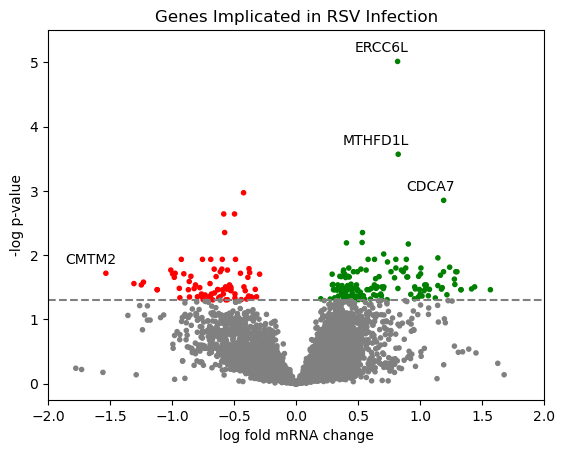

In [14]:
# Generate list of colors for plotting
color_list = []

for i in range(len(gene_signals.index)):
    if not gene_signals.iloc[i]['Reject?']:
        color_list.append('gray')
    elif gene_signals.iloc[i]['Mean Diff'] > 0:
        color_list.append('green')
    else:
        color_list.append('red')

x = gene_signals["Mean Diff"]
y = -np.log10(gene_signals["Adjusted p-values"])

plt.scatter(x, y, c = color_list, marker = '.')

plt.xlabel("log fold mRNA change")
plt.ylabel("-log p-value")
plt.title("Genes Implicated in RSV Infection")
plt.xlim(-2, 2)
plt.ylim(top = 5.5)
plt.axhline(y = -np.log10(0.05), ls = '--', color = 'gray')

labels = ['ERCC6L', 'MTHFD1L', 'CDCA7', 'CMTM2']
for label in labels:
    idx = gene_signals.index.get_loc(label)
    plt.annotate(label, xy = (x[idx], y[idx] + 0.1), xytext = (8, 0), textcoords = 'offset points', ha = 'right', va = 'bottom')

plt.savefig("../OUTPUTS/sig_volcano.png")
plt.show()

In [154]:
last = len(candidate_signals.columns) - 4

color_list = []
for patient in candidate_signals.columns[:last]:
    if int(candidate_signals.loc['Group'][patient]) == 0:
        color_list.append('blue')
    elif int(candidate_signals.loc['Group'][patient]) == 1:
        if candidate_signals.loc['Severity'][patient] == 'severe':
            color_list.append('red')
        elif candidate_signals.loc['Severity'][patient] == 'mild':
            color_list.append('red')
    else:
        color_list.append('gray')


## Building a model for regulation

Here, we want to use our data to model CDCA7 and CCNA2 dynamics under steady state conditions.
Let's start with a simple model for regulation, where CCNA2 transcription produced at a rate $\beta$ and degraded at a rate $\alpha$.

$$\frac{d[\text{CCNA2}]}{dt} = \beta - \alpha [\text{CCNA2}]$$

Since CDCA7 is a transcriptional activactor of CCNA2, we consider $\beta$ as a function of CDCA7 concentration, proxied by CDCA7 expression, with maximum activator activity $\beta_{max}$ and activation coefficient $K_m$. Here, we use the Hill function to model CDCA7 activity, with Hill coefficient $n$.

$$\beta([\text{CDCA7}]^n) = \beta_{max} \frac{[\text{CDCA7}]^n}{K_m + [\text{CDCA7}]^n}$$

Since we want to model steady state conditions...
$$\frac{d[\text{CCNA2}]}{dt} = \frac{d[\text{CDCA7}]}{dt} = 0$$

Considering this and subsituting $\beta([\text{CDCA7}]^n)$ in for $\beta$, we get:
$$[\text{CCNA2}] = \frac{\beta_{max} [\text{CDCA7}]^n}{\alpha (K_m + [\text{CDCA7}]^n)}$$

### Fitting the model to the data
We use the curve_fit function to determine parameters $\frac{\beta_{max}}{\alpha}$, $K_m$, and $n$ that will give our model the best fit to the data.

### Other possible models
Qualitatively, when we plot CCNA2 expression CDCA7 expression, the data appear to be linearly related. Additionally, when we plot log2 transformed expression data, the plot appears qualitatively linear, suggesting our data might be represented by a power function (might be linear). Hence, we obtain linear and power function models of the expression values and use these fits as potential models for our data. 

Note: the linear fit of the log2 expression values was used to produce a power function model as such:
$$
\begin{align}
\log_2[\text{CCNA2}] &= a \log_2[\text{CDCA7}] + \log_2 b \\
[\text{CCNA2}] &= b [\text{CDCA7}]^a
\end{align}
$$

To evaluate fits of the models, RMSE values were calucated for each. The simple regulation model had the lowest RMSE, followed by the linear model, then the power function model. Hence, the simple regulation model had the best fit among the three.

### Residual analysis

To further analyze the fit of our simple regulation model, we confirmed that our residuals were normally distributed. The residuals do not appear to have any patterns when plotted. Additionally, their distribution seems to follow a normal distribution, which is supported by the points on the Normal Q-Q plot falling along the line $y = x$, as well as the Shapiro-Wilk test: statistic=0.9682475328445435, pvalue=0.0980084016919136 (Note: the relatively low p-value may be explained by the small sample size).


beta_max/alpha, Km, n:  [489.08265971  94.62418929   1.0846144 ]


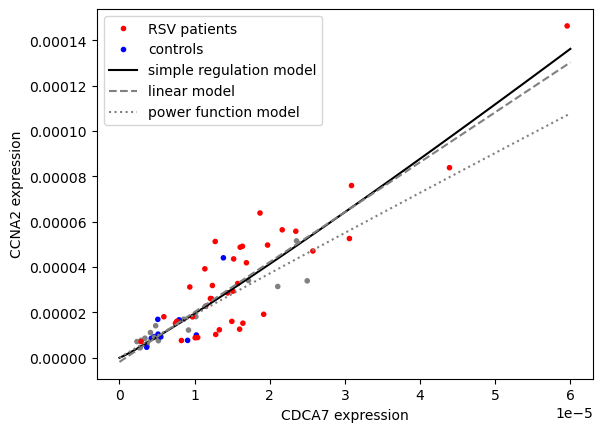

Simple regulation model RMSE:  1.0252108626262895e-05
Linear model RMSE:  1.0349487383763187e-05
Power function model RMSE:  1.1407318642996384e-05


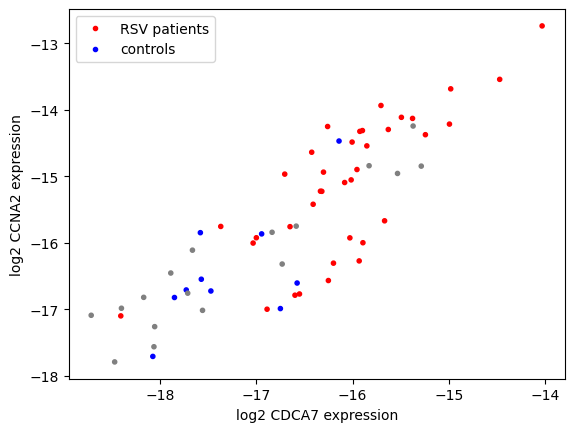

In [292]:
# get normalized data for CDCA7 and CCNA2
log2_x = candidate_signals.loc['CDCA7'][:last].to_numpy()
log2_x = [float(n) for n in log2_x]
log2_y = candidate_signals.loc['CCNA2'][:last].to_numpy()
log2_y = [float(n) for n in log2_y]

# get expression values (not log2)
x = [2 ** float(n) for n in log2_x]
y = [2 ** float(n) for n in log2_y]

# simple regulation model (cdca7 = CDCA7 expression, beta_alpha = max CDCA7 activation activity / CCNA2 degradation rate)
def ccna2_model(cdca7, beta_alpha, K_m, n):
    return beta_alpha * (cdca7 ** n) / (K_m + cdca7 ** n)

# curve fit to get parameters for best fit
beta_alpha, K_m, n = curve_fit(ccna2_model, x, y)[0]
print('beta_max/alpha, Km, n: ', params)

# linear fit
slope, incpt = np.polyfit(x, y, 1)

# linear fit of log2 values for power function fit
log2_slope, log2_incpt = np.polyfit(log2_x, log2_y, 1)

x_fit = np.linspace(0, 6 * 10 ** (-5), 100)

# plot the data and the curves
plt.scatter(x, y, marker='.', color=color_list)
plt.plot(x_fit, ccna2_model(x_fit, beta_alpha, K_m, n), color = 'k', label = 'simple regulation model')
plt.plot(x_fit, slope * x_fit + incpt, color = 'gray', ls = '--', label = 'linear model')
plt.plot(x_fit, (2 ** log2_incpt) * (x_fit ** log2_slope), color = 'gray', ls = ':', label = 'power function model')

# plot labels
red_point = mlines.Line2D([], [], color='red', marker='.', ls='', label='RSV patients')
blue_point = mlines.Line2D([], [], color='blue', marker='.', ls='', label='controls')
black_line = mlines.Line2D([], [], color='black', label='simple regulation model')
grey_dashed_line = mlines.Line2D([], [], color='gray', ls='--', label='linear model')
grey_dotted_line = mlines.Line2D([], [], color='gray', ls=':', label='power function model')
plt.legend(handles = [red_point, blue_point, black_line, grey_dashed_line, grey_dotted_line])

plt.xlabel('CDCA7 expression')
plt.ylabel('CCNA2 expression')
plt.show()

# plot log2 transformed data
plt.scatter(log2_x, log2_y, marker='.', color=color_list)
plt.xlabel('log2 CDCA7 expression')
plt.ylabel('log2 CCNA2 expression')
plt.legend(handles = [red_point, blue_point])

# calculate RMSE of each model

# RMSE of simple regulation model
resids = y - ccna2_model(x, beta_alpha, K_m, n)
rmse = np.sqrt(sum(resids ** 2) / len(resids))

# RMSE of linear model
resids_lin = [y[i] - (lin_fit[0] * x[i] + lin_fit[1]) for i in range(len(y))]
resids_sq_lin = [resid ** 2 for resid in resids_lin]
rmse_lin = np.sqrt(sum(resids_sq_lin) / len(resids_lin))

# RMSE of power function model
resids_log = [y[i] - (2 ** log2_incpt) * (x[i] ** log2_slope) for i in range(len(y))]
resids_sq_log = [resid ** 2 for resid in resids_log]
rmse_log = np.sqrt(sum(resids_sq_log) / len(resids_log))

print('Simple regulation model RMSE: ', rmse)
print('Linear model RMSE: ', rmse_lin)
print('Power function model RMSE: ', rmse_log)


0


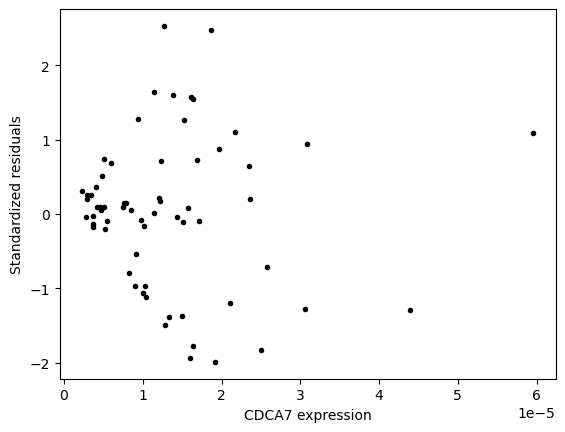

ShapiroResult(statistic=0.9682475328445435, pvalue=0.0980084016919136)


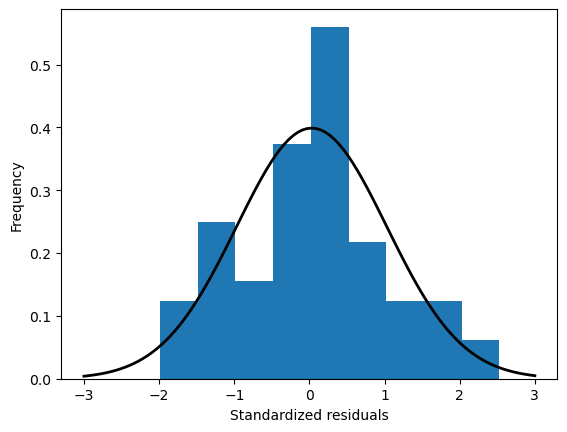

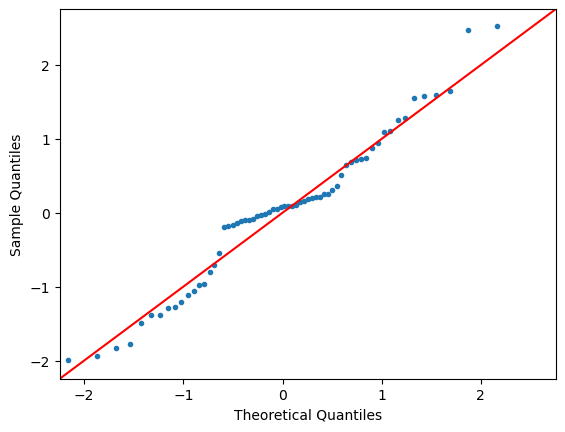

In [288]:
# plot residuals to make sure there is no pattern
res_std = resids.std()
std_res = resids / res_std
stud_res = [res * np.sqrt((len(resids) - 1 - 2) / (len(resids) - 1 - 1 - res ** 2)) for res in std_res]

# studentized residuals to identify outliers
outliers = []
for res in stud_res:
    if abs(res) > 3:
        outliers.append(res)

# no outliers
print(len(outliers))

plt.scatter(x, std_res, marker = '.', color = 'k')
plt.xlabel('CDCA7 expression')
plt.ylabel('Standardized residuals')
plt.show()

# Plot the PDF
plt.hist(std_res, bins=9, density=True)
plt.xlabel('Standardized residuals')
plt.ylabel('Frequency')

mu, std = norm.fit(std_res) 

xmin, xmax = -3, 3
x_norm = np.linspace(xmin, xmax, 100)
p = norm.pdf(x_norm, mu, std)
plt.plot(x_norm, p, 'k', linewidth=2)

# Normalized Q-Q plot
sm.qqplot(std_res, line = '45', marker = '.')

# test for normal distribution
print(shapiro(std_res))